In [1]:
from simulation import Simulation
import random
import numpy as np
import matplotlib.pyplot as plt

# Important for animation to run inline
%matplotlib ipympl

# Create a pipeline

In [2]:
class AugmentationPipeline():
    def __init__(self):
        self.fliph = random.randint(0, 1)
        self.flipv = random.randint(0, 1)
        self.rotate = [0,90,180,270][random.randint(0, 3)]

    def __repr__(self):
        return f"Horizontal flip:\t{self.fliph} \nVertical flip:\t\t{self.flipv} \nRotation angle:\t\t{self.rotate}"

    def transform_2D(self, data):
        """
        Transformation of 2D data. Input:
        data: 2D array
        """
        if self.fliph == 1:
            data = data[:, ::-1]
        
        if self.flipv == 1:
            data = data[::-1, :]
        
        if self.rotate:
            for i in range(self.rotate//90):
                # Rotation is defined positive clockwise
                data = np.rot90(data)

        return data

    def transform_3D(self, data):
        """
        Transformation of gridded vector data. Input:
        data: 3D array --> 2D grid with a vector defined at each point.
        dir: x or y

        returns: augmented data
        """
        # Step 1: transform the data similarly to 2D
        if self.fliph:
            data = data[:, ::-1]
            data[:,:,0] *= -1
        
        if self.flipv:
            data = data[::-1, :]
            data[:,:,1] *= -1
        
        if self.rotate:
            for i in range(self.rotate//90):
                # Rotation is defined positive clockwise
                data = np.rot90(data)
                
        aug_data1 = data

        # # Step 2: rotate the vectors
        # The rotation theorem was obtained from https://matthew-brett.github.io/teaching/rotation_2d.html
        # Rotation angle should be converted to radians.
        aug_data2 = np.zeros(aug_data1.shape)
        aug_data2[:,:,0] = aug_data1[:,:,0] * np.cos(-self.rotate * 2*np.pi/360) - aug_data1[:,:,1] * np.sin(-self.rotate * 2*np.pi/360)
        aug_data2[:,:,1] = aug_data1[:,:,0] * np.sin(-self.rotate * 2*np.pi/360) + aug_data1[:,:,1] * np.cos(-self.rotate * 2*np.pi/360)

        return aug_data2
    
    def transform_simulation(self, sim):
        """Function to transform a simulation.
        Input:
         -sim: a simulation object

         returns:
         - aug_sim: new simulation object, which is a transformation of the input simulation.
         """
        topo = sim.topography
        wd = sim.wd
        vx = sim.vx
        vy = sim.vy
        wd_aug = np.zeros(wd.shape)
        vx_aug = np.zeros(vx.shape)
        vy_aug = np.zeros(vy.shape)

        topo_aug = self.transform_2D(topo)

        for i in range(wd.shape[0]):

            wd_, vx_, vy_ = sim.return_timestep(i)

            vxvy = np.zeros((vx_.shape[0], vx_.shape[1], 2))
            vxvy[:,:,0] = vx_
            vxvy[:,:,1] = vy_

            wd_aug[i] = self.transform_2D(wd_)
            vxvy_aug = self.transform_3D(vxvy)

            vx_aug[i] = vxvy_aug[:,:,0]
            vy_aug[i] = vxvy_aug[:,:,1]

        aug_sim = Simulation(topo_aug, wd_aug, vx_aug, vy_aug)
        
        return aug_sim

# Load data

In [3]:
number_grids = 64
save_folder = "../data/raw_datasets"
sim = 42

topo = np.loadtxt(f"{save_folder}\\DEM\\DEM_{sim}.txt")[:, 2].reshape(number_grids,number_grids)
wd = np.loadtxt(f"{save_folder}\\WD\\WD_{sim}.txt").reshape(-1,number_grids,number_grids)
vx = np.loadtxt(f"{save_folder}\\VX\\VX_{sim}.txt").reshape(-1,number_grids,number_grids)
vy = np.loadtxt(f"{save_folder}\\vy\\vy_{sim}.txt").reshape(-1,number_grids,number_grids)

test_sim = Simulation(topo, wd, vx, vy)

### First, we test some individual operations

In [4]:
fix, axs = plt.subplots(1,4)
axs[0].imshow(topo, cmap="terrain")

# Horizontal flip
topo_aug = topo[:, ::-1]
axs[1].imshow(topo_aug, cmap="terrain")

# Vertical flip
topo_aug = topo[::-1, :]
axs[2].imshow(topo_aug, cmap="terrain")

# 90 deg
rot = 90
topo_aug = topo
for i in range(rot//90):
    topo_aug = np.rot90(topo_aug, -1)
axs[3].imshow(topo_aug, cmap="terrain")

# # Remove to show the plots
plt.close()

### Second, test entire pipeline

In [8]:
test_pipeline = AugmentationPipeline()

aug_sim = test_pipeline.transform_simulation(test_sim)

Horizontal flip:	0 
Vertical flip:		1 
Rotation angle:		0


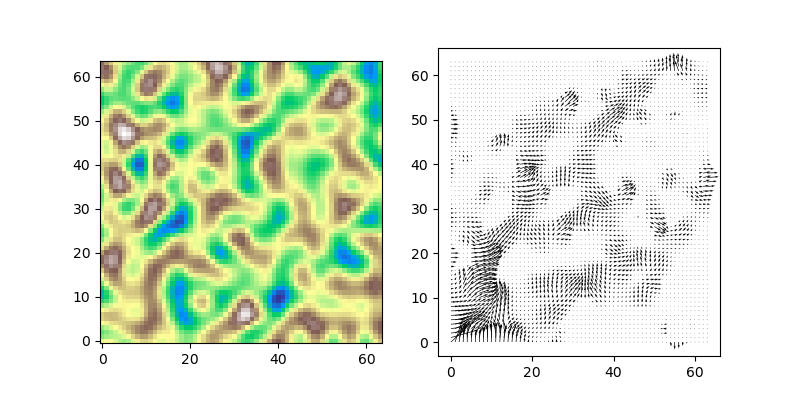

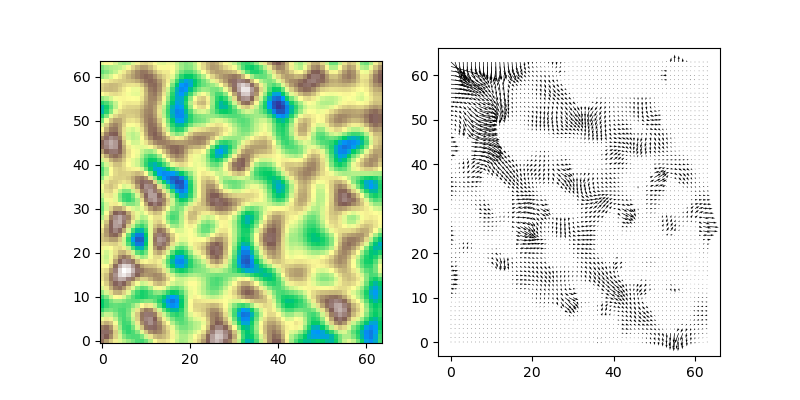

In [9]:
# Test vector plot
fig = test_sim.plot_vector(-1)
fig = aug_sim.plot_vector(-1)

print(test_pipeline)

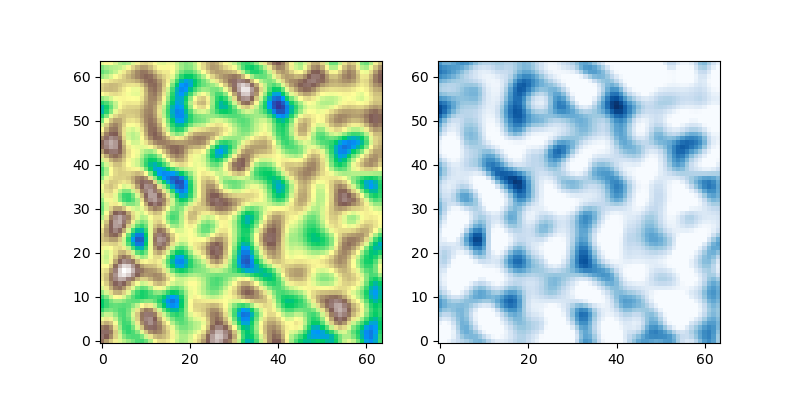

In [10]:
# Test animation
ani = aug_sim.plot_animation()